# Pump failure data -  Stan

#### Josep Fortiana 2018-12-17

A benchmark hierarchical example in the Gibbs sampling literature describes the number of failures and times of observation of ten pumps in a nuclear plant, with the data given in the following table:
	
$$
\begin{array}{l|cccccccccc}
	\hline
	\text{Pump}    &1		&2		&3		&4		&5		&6		&7		&8		&9		&10\\[0.2cm]
	\hline
	\text{Failures}&5		&1		&5		&14		&3		&19		&1		&1		&4		&22\\[0.2cm]
	\text{Time}	&94.32 	&15.72 	&62.88 	&125.76 &5.24 	&31.44 	&1.05 	&1.05 	&2.10 	&10.48\\[0.2cm]
	\hline
\end{array}
$$

Source: Gaver, D. P. & O'Muircheartaigh, I G. (1987). _Robust empirical Bayes analysis of event rates._ Technometrics 29, No. 1, pp. 1-15.

In [1]:
#install.packages("ggplot2", repos= "https://cloud.r-project.org")
#install.packages("StanHeaders", repos= "https://cloud.r-project.org")
#install.packages("rstan", repos= "https://cloud.r-project.org")
require(rstan)

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For improved execution time, we recommend calling
Sys.setenv(LOCAL_CPPFLAGS = '-march=native')
although this causes Stan to throw an error on a few processors.


In [2]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=native')

## Data 

In [3]:
n<-10
t<-c(94.3, 15.7, 62.9, 126, 5.24, 31.4, 1.05, 1.05, 2.1, 10.5)
x<-c(5, 1, 5, 14, 3, 19, 1, 1, 4, 22)
pump.dataList<-list(
    x = x,
    t = t,
    n = n 
    )

### Specify model

In [4]:
pump.modelString<-"
data {
  int<lower=0> n;
  int<lower=0> x[n];
  vector[n]  t;
}

parameters {
  real<lower=0> alpha;
  real<lower=0> beta;
  vector<lower=0>[n] lambda;
}

model {
  alpha ~ exponential(1.0);
  beta ~ gamma(0.1, 1.0);
  lambda ~ gamma(alpha, beta);
  x ~ poisson(lambda .* t);
}
" # close quote for modelString

Note the elementwise product in: `x ~ poisson(lambda .* t)`

### Translate model to C++ and compile to _Dynamic Shared Object (DSO)_

In [5]:
pump.stanDso<-stan_model(model_code=pump.modelString)

### Generate posterior sample

In [6]:
pump.stanFit<-sampling(
        object=pump.stanDso, 
        data = pump.dataList, 
        chains = 4 ,
        iter = 2000 , 
        warmup = 500 , 
        thin = 1
        )

In [7]:
S<-summary(pump.stanFit)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,0.699,0.004,0.267,0.298,0.507,0.661,0.848,1.297,3747.477,1.000
beta,0.931,0.008,0.535,0.187,0.546,0.833,1.210,2.250,3963.961,1.000
lambda[1],0.060,0.000,0.025,0.021,0.041,0.056,0.074,0.118,6583.696,1.000
lambda[2],0.101,0.001,0.079,0.009,0.043,0.083,0.139,0.306,7054.356,1.000
lambda[3],0.089,0.000,0.038,0.031,0.062,0.084,0.111,0.179,6711.841,1.000
lambda[4],0.116,0.000,0.031,0.063,0.095,0.114,0.135,0.184,8120.613,1.000
lambda[5],0.597,0.003,0.316,0.156,0.360,0.541,0.772,1.343,8289.152,1.000
lambda[6],0.610,0.002,0.136,0.373,0.513,0.601,0.696,0.907,7402.947,1.000
lambda[7],0.878,0.008,0.703,0.076,0.376,0.691,1.192,2.643,7303.708,1.000
lambda[8],0.879,0.009,0.695,0.071,0.375,0.708,1.187,2.695,5617.669,1.000


### Classical ML estimates

In [8]:
# Either each lambda.i is ML-estimated from a single observation as x.i/t.i
lambda.ML<-x/t
# or a common lambda is ML-estimated as the average of the above
mean.lambda.ML<-mean(lambda.ML)
round(lambda.ML,2)
round(mean.lambda.ML,2)

[1] 0.05 0.06 0.08 0.11 0.57 0.61 0.95 0.95 1.90 2.10

[1] 0.74

Note: in the paper _Reader Reaction: A Re-Analysis of the Pump-Failure Data (with Response),_ by
J. A. Nelder, E. I. George, U. E. Makov and A. F. M. Smith, Scandinavian Journal of Statistics, Vol. 21, No. 2 
(Jun., 1994), pp. 187-191, they notice that in this dataset, pumps 1, 3, 4, and 6 were operated continuously, whereas
the remaining ones were operated intermittently. Then they show that an improved fit is obtained when this difference
is taken into account.

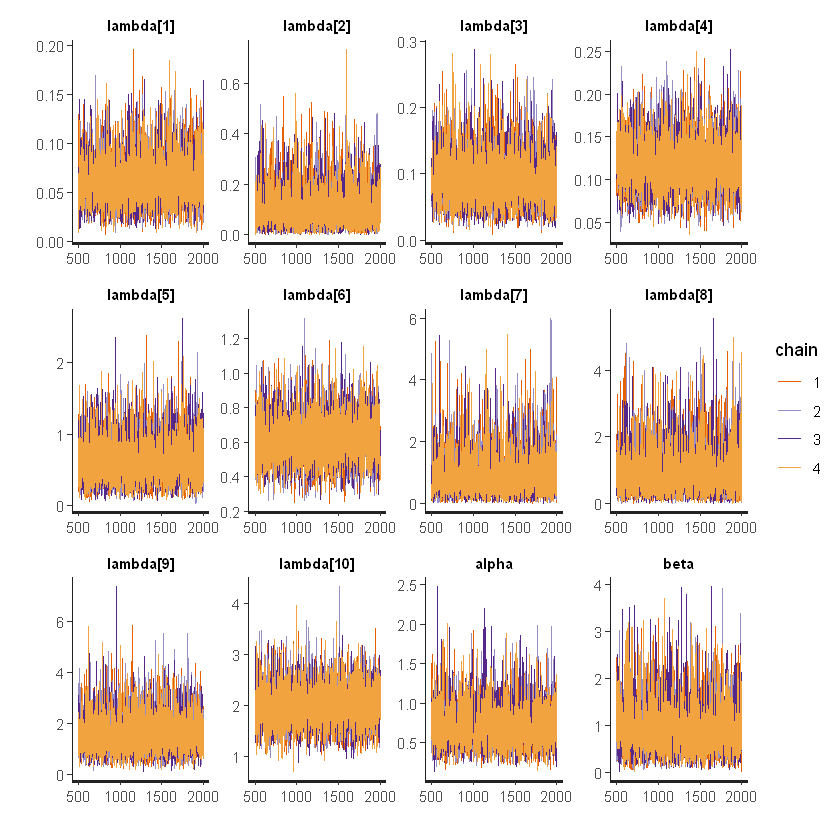

In [9]:
stan_trace(pump.stanFit, pars=c("lambda","alpha","beta"))

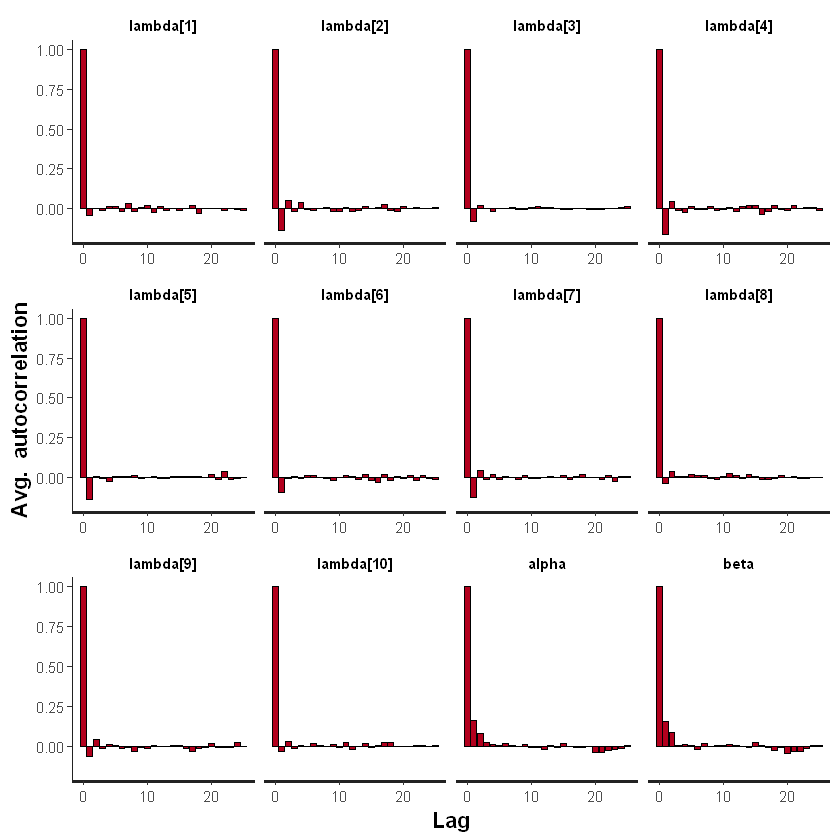

In [10]:
stan_ac(pump.stanFit, pars=c("lambda","alpha","beta"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


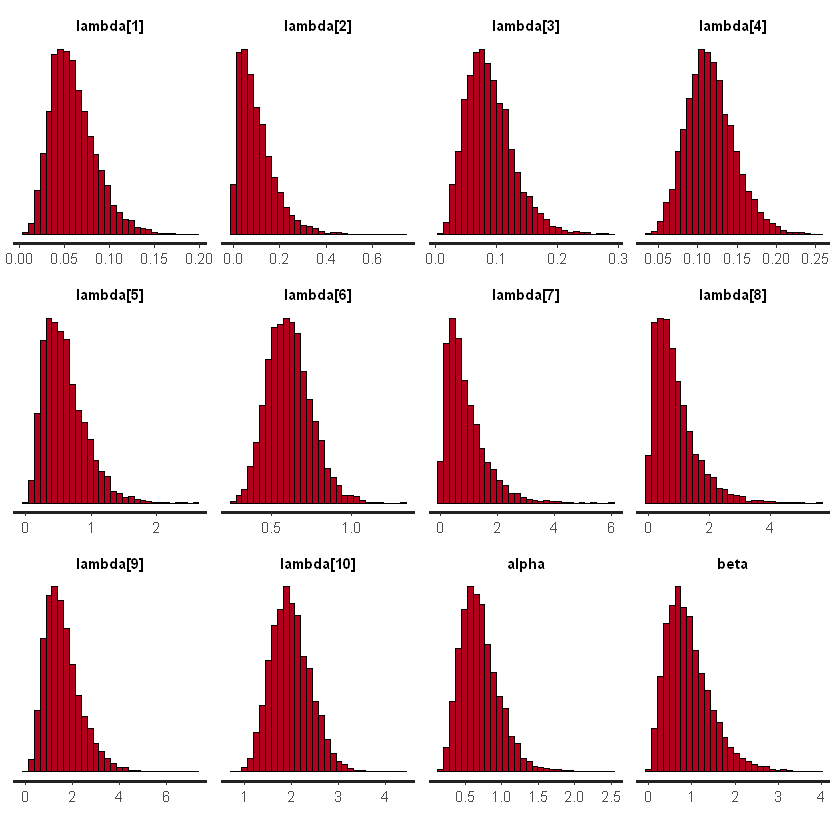

In [11]:
stan_hist(pump.stanFit, pars=c("lambda","alpha","beta"))

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


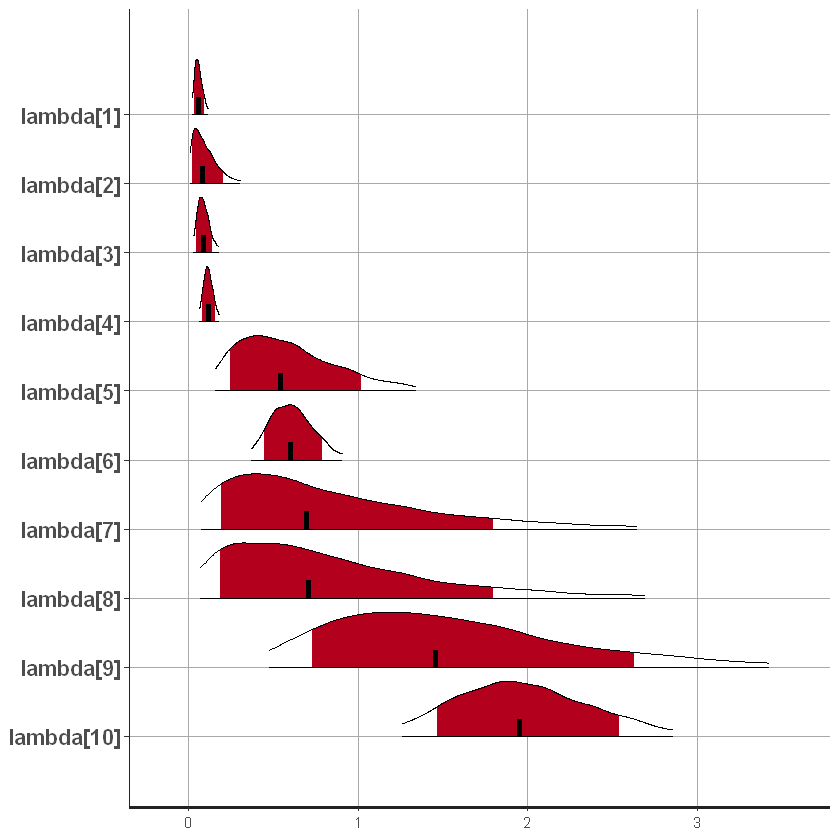

In [12]:
stan_plot(pump.stanFit, pars=c("lambda"),show_density = TRUE)

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


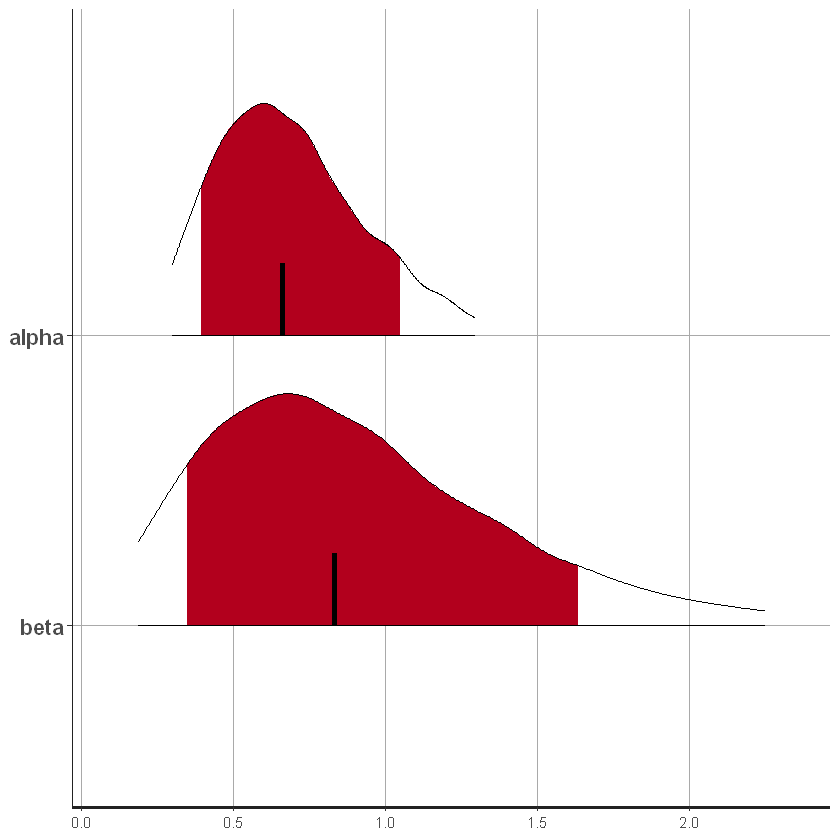

In [13]:
stan_plot(pump.stanFit, pars=c("alpha","beta"),show_density = TRUE)